# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Технологический процесс**    
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота   

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи     

**Наименование признаков**      

**Наименование признаков должно быть такое:**                    
[этап].[тип_параметра].[название_параметра]                 
*Пример: rougher.input.feed_ag*                
**Возможные значения для блока [этап]:** 
* rougher — флотация                 
* primary_cleaner — первичная очистка       
* secondary_cleaner — вторичная очистка      
* final — финальные характеристики 

**Возможные значения для блока [тип_параметра]:**     
* input — параметры сырья         
* output — параметры продукта           
* state — параметры, характеризующие текущее состояние этапа                        
* calculation — расчётные характеристики             

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery

# 1. Подготовка данных

### 1.1. Откройте файлы и изучите их.

Загружаем необходимые бибиолиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

загружаем данные

In [2]:
train= pd.read_csv('/datasets/gold_recovery_train.csv',parse_dates=True, index_col='date')
test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=True, index_col='date')
full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=True, index_col='date')

Первичный осмотр всех таблиц:

In [3]:
display(train.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
display(test.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
display(full.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

**Вывод**    
Во всех таблицах имеются пропуски в целевых признаках и обычных признаках.    
Их необходимо заполнить.    
В форматах данных ошибок нет.

#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Так как данные сырые предположим, что в полном датасете меньше пропусков, поэтому присвоим по индексам значения из full в train

In [9]:
train.isna().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

In [10]:
full.isna().sum()

final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

In [11]:
good_train = full.loc[train.index]

Проверим изменилось ли, что нибудь

In [12]:
train.shape


(16860, 86)

In [13]:
good_train.shape

(16860, 86)

In [14]:
good_train.isna().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

Данный способ заполнения пропусков не дал результатов, количество пропусков не изменилось.

Напишем функцию для расчёта Recovery

In [15]:
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    numerator = (c*(f-t))
    denominator =(f*(c-t))
    rec = numerator / denominator * 100
    if rec>100:
        rec=0
    if rec<0:
        rec=0
    return rec

Применим фукнцию.

In [16]:
good_train['recovery_test'] = good_train.apply(recovery, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Для корректного расчёта MAE, заполним нулями сравниваемые столбцы, так как MAE не работает с пропусками.

In [17]:
good_train['rougher.output.recovery'] =good_train['rougher.output.recovery'].fillna(0)

In [18]:
good_train['recovery_test'] =good_train['recovery_test'].fillna(0)

Посчитаем MAE

In [19]:
print(mean_absolute_error(good_train['rougher.output.recovery'],good_train['recovery_test']))

8.188520377116694e-15


**Вывод**    
Расчёт применённый в датасете можно считать корректным. Отклонение в 8.18 не является большим и мы можем списать его на заполеннные нулями значения.

#### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Проверим какие столбцы отсутствуют в тестеовой выборке.

In [20]:
del_list = set(train.columns) - set(test.columns)

In [21]:
del_list

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [22]:
del_list = ['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol']

**Вывод**     
В тесте отсутствуют все данные, которые не могут быть заранее известны и расчитываются в ходе процесса очистки руды

#### 1.4. Проведите предобработку данных.

Для заполнения пропусков в трейне и тесте я буду использовать данне из фулл выборки. Поэтому обрабатывать буду её

In [23]:
prepared_full = full

удалим пропуски в целевом признаке.

In [24]:
prepared_full = prepared_full.dropna(subset=['final.output.recovery'])

In [25]:
prepared_full = prepared_full.dropna(subset=['rougher.output.recovery'])

Пропуски в остальных признаках заполним методом ffill т.к. данные в соседних строках не сильно отличаются.

In [26]:
prepared_full = prepared_full.fillna(method='ffill')

Предобработку данных закончена

# 2. Анализ данных

#### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Создаем цикл для построение графиков по содержанию металлов на разных этапах очистки в отвальных хвастах и основном сырье

In [27]:
metals =['ag','au','pb']

In [28]:
stages = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']

In [29]:
stages_end = ['rougher.input.feed_','rougher.output.tail_','primary_cleaner.output.tail_','final.output.tail_']

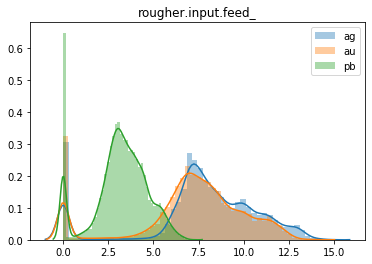

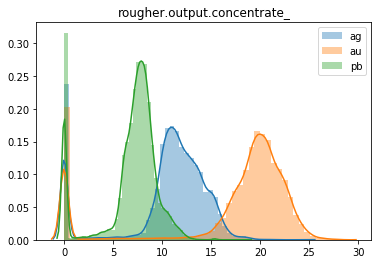

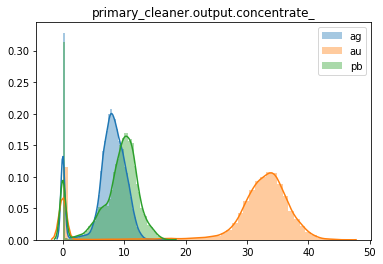

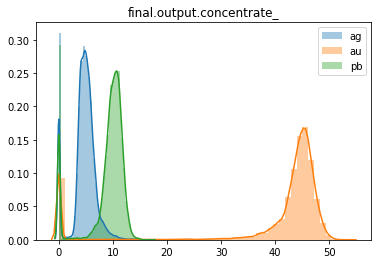

In [30]:
for stage in stages:
    for metal in metals:
        cols = full.columns.str.contains(stage+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal) 
        sns_ax.set_title(stage)
    plt.legend()
    plt.show()
        

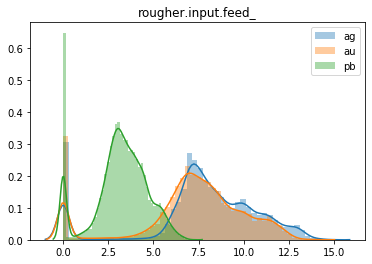

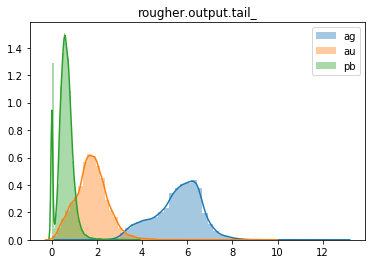

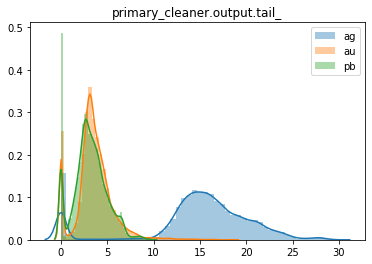

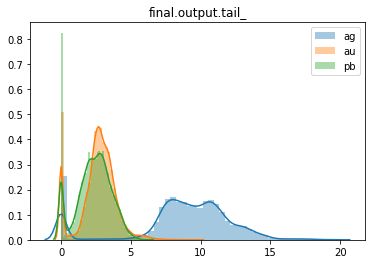

In [31]:
for stage in stages_end:
    for metal in metals:
        cols = full.columns.str.contains(stage+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal) 
        sns_ax.set_title(stage)
    plt.legend()
    plt.show()

**Вывод**     
Из графиков видно, что содеражние золота увеличивается в ходе процесса обработке в основнмо сырье, а в отвальных хвостах уменьшается. Можно сделать вывод, что процесс проходит корректно.

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Построим сравнительный график размеров гранул в тестовой и обучающей выборке.

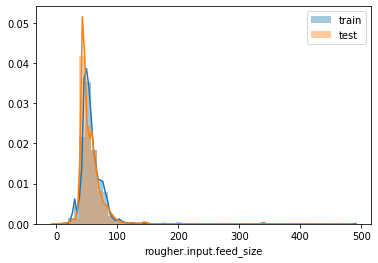

In [32]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

**Выводы**        
Размеры гранул примерно практически совпадают, данные можно считать корректными.

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Построим цикл для построения графиков суммарной концентрации веществ.

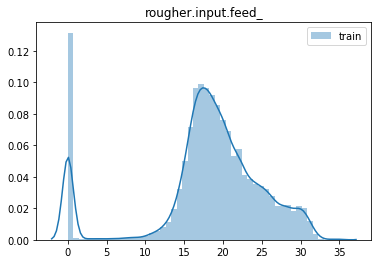

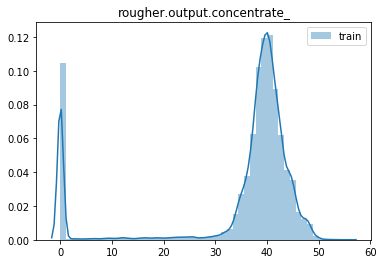

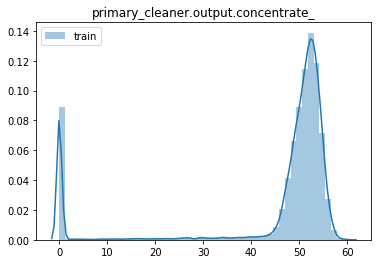

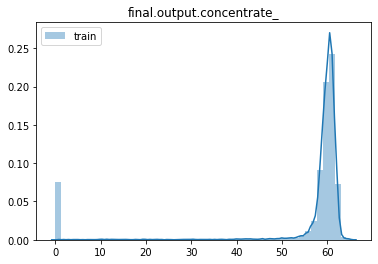

In [33]:
for stage in stages:
    sum_train = train[stage+ 'ag'] + train[stage+ 'au'] + train[stage+ 'pb']
    sns.distplot(sum_train.dropna(), label='train')  
    plt.title(stage)
    plt.legend()
    plt.show()

**Вывод**           
Наблюдаются выбросы по всем этапам в районе от 0 до 5. Стоим их убрать

#### 2.4. Обработка выбросов

Удалим выбросы из датасета full.

Посмотрим сколько строчек данных до обработки и сколько будет после.

In [34]:
prepared_full.shape

(19439, 86)

Пишем цикл для новых столбцов с суммарным содеражнием металлов по этапам.

In [35]:
for stage in stages:
    prepared_full['sum_'+stage] = prepared_full[stage+ 'ag'] + prepared_full[stage+ 'au'] + prepared_full[stage+ 'pb']
    print( prepared_full['sum_'+stage])

date
2016-01-15 00:00:00    14.871440
2016-01-15 01:00:00    14.905729
2016-01-15 02:00:00    14.638299
2016-01-15 03:00:00    14.199305
2016-01-15 04:00:00    13.511497
                         ...    
2018-08-18 06:59:59    16.045275
2018-08-18 07:59:59    15.104931
2018-08-18 08:59:59    14.515579
2018-08-18 09:59:59    14.313448
2018-08-18 10:59:59    14.399936
Name: sum_rougher.input.feed_, Length: 19439, dtype: float64
date
2016-01-15 00:00:00    38.395653
2016-01-15 01:00:00    38.945647
2016-01-15 02:00:00    38.649756
2016-01-15 03:00:00    38.411473
2016-01-15 04:00:00    38.867359
                         ...    
2018-08-18 06:59:59    40.712449
2018-08-18 07:59:59    40.755632
2018-08-18 08:59:59    32.589863
2018-08-18 09:59:59    40.148948
2018-08-18 10:59:59    40.465768
Name: sum_rougher.output.concentrate_, Length: 19439, dtype: float64
date
2016-01-15 00:00:00    53.111627
2016-01-15 01:00:00    53.174338
2016-01-15 02:00:00    52.927464
2016-01-15 03:00:00    43.9791

Удалим выбросы.

In [36]:
# prepared_full = prepared_full.loc[prepared_full['sum_rougher.input.feed_']>5]
# prepared_full = prepared_full.loc[prepared_full['sum_rougher.output.concentrate_']>5]
# prepared_full = prepared_full.loc[prepared_full['sum_primary_cleaner.output.concentrate_']>5]
# prepared_full = prepared_full.loc[prepared_full['sum_final.output.concentrate_']>5]

Проверим сколько осталось строк в датасете

In [37]:
prepared_full.shape

(19439, 90)

Убрали примерно 700 выбросов.

# 3. Модель

#### 3.1. Напишите функцию для вычисления итоговой sMAPE.

Напишем фукнцию для расчёта sMape

In [38]:
def smape(target,pred):
    return np.mean((np.abs(target-pred))/((np.abs(target)+np.abs(pred))/2)*100)

In [39]:
def final_smape(smape_rougher, smape_final):
    return 0.25* smape_rougher + 0.75*smape_final

In [40]:
custom_scorer = make_scorer(smape, greater_is_better = False)

#### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Так как мы обрабатывали датасет full обновим данные в train

In [41]:
prepared_train = prepared_full.query('index in @train.index')

Так как у нас 2 целевых признака то будем обучать 2 модели , на 2 разных датасетах, в которых информация соответствуют технологическому процессу.

Посмотрим на все доступные нам данные.

In [42]:
prepared_train.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

Напишем данные, которые доступны для первого целевого признака **rougher.output.recovery**

In [43]:
first_stage_columns = ['rougher.input.feed_pb',
                                    'rougher.input.feed_rate',
                                    'rougher.input.feed_size',
                                    'rougher.input.feed_sol',
                                    'rougher.input.feed_au',
                                    'rougher.input.floatbank10_sulfate',
                                    'rougher.input.floatbank10_xanthate',
                                    'rougher.input.floatbank11_sulfate',
                                    'rougher.input.floatbank11_xanthate',
                                    'rougher.output.recovery',
                                    'rougher.state.floatbank10_a_air',
                                    'rougher.state.floatbank10_a_level',
                                    'rougher.state.floatbank10_b_air',
                                    'rougher.state.floatbank10_b_level',
                                    'rougher.state.floatbank10_c_air',
                                    'rougher.state.floatbank10_c_level',
                                    'rougher.state.floatbank10_d_air',
                                    'rougher.state.floatbank10_d_level',
                                    'rougher.state.floatbank10_e_air',
                                    'rougher.state.floatbank10_e_level',
                                    'rougher.state.floatbank10_f_air',
                                    'rougher.state.floatbank10_f_level'
                                   ]

Логика следующая, у нас 3 этапа обработки сырья ( флотация -> первый этап очистки -> второй этап очистки).<br>
Целевой признак **rougher.output.recovery** является итогом флотация, поэтому данные, которые относятся к следующим этапам нам не помогут. Тем более по логике процесса, они нам и не могут быть известны если эти этапы ещё не начаты </font>

Проверим, есть ли столбцы которые я выбрал для 1ого этапа в тестовом выборке

In [44]:
set(first_stage_columns) - set(test.columns)

{'rougher.output.recovery'}

 Все столбцы есть в тестовой кроме одного, но он является целевым признаком поэтому это нормально. 

Создаём новый дадасет с только с признакми для первого этапа.

In [45]:
prepared_train_1st_stage = prepared_train[first_stage_columns]

In [46]:
prepared_train_1st_stage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 22 columns):
rougher.input.feed_pb                 14149 non-null float64
rougher.input.feed_rate               14149 non-null float64
rougher.input.feed_size               14149 non-null float64
rougher.input.feed_sol                14149 non-null float64
rougher.input.feed_au                 14149 non-null float64
rougher.input.floatbank10_sulfate     14149 non-null float64
rougher.input.floatbank10_xanthate    14149 non-null float64
rougher.input.floatbank11_sulfate     14149 non-null float64
rougher.input.floatbank11_xanthate    14149 non-null float64
rougher.output.recovery               14149 non-null float64
rougher.state.floatbank10_a_air       14149 non-null float64
rougher.state.floatbank10_a_level     14149 non-null float64
rougher.state.floatbank10_b_air       14149 non-null float64
rougher.state.floatbank10_b_level     14149 non-null float64
ro

Всё ок двигаемся дальше

Делим на features и target

In [47]:
prepared_train_1st_stage_train = prepared_train_1st_stage.drop('rougher.output.recovery', axis=1)

In [48]:
prepared_train_1st_stage_target = prepared_train_1st_stage['rougher.output.recovery']

In [49]:
prepared_train_1st_stage_train.columns

Index(['rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

### 3.2.1 Подбор модели и кросс валидация

Обучим несколько моделей и проведём кросс валидацию.

### 1 этап нахождение rougher.output.recovery

#### 3.2.1.1 LinearRegression

Используя GridSearch найдём лучшие параметры для модели

In [50]:
param_grid_logres = {'fit_intercept':['True','False'],
                    'normalize':['True','False'],
                    }

In [51]:
#gs_logres_1st_stage = GridSearchCV(LinearRegression(), param_grid = param_grid_logres) // закоментил так как очень долго прогоняет этот код
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [52]:
#gs_logres_1st_stage.fit(prepared_train_1st_stage_train, prepared_train_1st_stage_target) 

In [53]:
#gs_logres_1st_stage.best_params_

Создадим модель с этими параметрами.

In [54]:
model_logres_1st_stage = LinearRegression(fit_intercept=True, normalize=True)

Проведём кросс-валидацию и посчитаем sMAPE

In [55]:
cv_logres = cross_val_score(model_logres_1st_stage,
                            prepared_train_1st_stage_train,
                            prepared_train_1st_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_logres = np.abs(sum(cv_logres) / len(cv_logres))

In [56]:
final_score_logres

17.034015578387848

#### 3.2.1.2 DecisionTreeRegressor

Аналогично предыдущей модели.

In [57]:
param_grid_dt = {'max_depth':[depth for depth in range(1,6)],
              'min_samples_split':[split for split in range(2,7,1)],
              'min_samples_leaf':[leaf for leaf in range(1,7,1)]}

In [58]:
#gs_dt_1st_stage = GridSearchCV(DecisionTreeRegressor(), param_grid = param_grid_dt)

In [59]:
#gs_dt_1st_stage.fit(prepared_train_1st_stage_train, prepared_train_1st_stage_target)

In [60]:
#gs_dt_1st_stage.best_params_

{'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 4}


In [61]:
model_dt_1st_stage = DecisionTreeRegressor(max_depth=4, min_samples_leaf=6, min_samples_split= 6,random_state=12345)

In [62]:
cv_dt = cross_val_score(model_dt_1st_stage,
                            prepared_train_1st_stage_train,
                            prepared_train_1st_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_dt = np.abs(sum(cv_dt) / len(cv_dt))

In [63]:
final_score_dt

18.099176417226094

#### 3.2.1.3 RandomForestRegressor()

Аналогично предыдущей модели

In [64]:
param_grid_rf = {'n_estimators': [n_estim for n_estim in range(50,100,10)],
                'max_depth': [depth for depth in range(1,6,1)],
                'min_samples_leaf':[leaf for leaf in range(1,6,1)]}

In [65]:
#gs_rf_1st_stage = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)


In [66]:
#gs_rf_1st_stage.fit(prepared_train_1st_stage_train, prepared_train_1st_stage_target)

In [67]:
#gs_rf_1st_stage.best_params_

{'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 60}

In [68]:
model_rf_1st_stage =RandomForestRegressor(random_state=12345,
                                          max_depth=4,
                                          min_samples_leaf=3,
                                          n_estimators=60
                                         )

In [69]:
cv_rf = cross_val_score(model_rf_1st_stage,
                            prepared_train_1st_stage_train,
                            prepared_train_1st_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_rf = np.abs(sum(cv_rf) / len(cv_rf))

In [70]:
final_score_rf

17.275970598812393

#### 2 этап нахождение final.output.recovery

~~Подготовим датасет для второго этапа, по логике процесса он будет включать в себя все столбцы из первоначального датасета тест~~

In [71]:
test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

 Составляю список столбцов, которые относятся ко второму целевому признаку **final.output.recovery**
    Логика процесса следующая, сюда мы добавляем столбцы, которые относятся к этапам первой очиски и второй очистки так как они являются признаками для целевого признака final.output.recovery и итог вычислений первого этапа, без дополнительных данных, которые нам уже не пригодятся.     
    Я приведу пример своих мыслей на простых числах т.к. мне кажется я плохо объясняю и тебе не совсем понятно о чём речь.
    (2+2) *2 = 8 
    мы ищем 8, и нам инетерсна сумма в первой скобке, а не что именно было в ней. (2+2) в нашем лучае результат первой модели, детали которой нам не инетерсны, а нужен только резульат.

In [72]:
second_stage_columns = ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
                        'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
                        'primary_cleaner.state.floatbank8_a_air',
                        'primary_cleaner.state.floatbank8_a_level',
                        'primary_cleaner.state.floatbank8_b_air',
                        'primary_cleaner.state.floatbank8_b_level',
                        'primary_cleaner.state.floatbank8_c_air',
                        'primary_cleaner.state.floatbank8_c_level',
                        'primary_cleaner.state.floatbank8_d_air',
                        'primary_cleaner.state.floatbank8_d_level',
                        'secondary_cleaner.state.floatbank2_a_air',
                        'secondary_cleaner.state.floatbank2_a_level',
                        'secondary_cleaner.state.floatbank2_b_air',
                        'secondary_cleaner.state.floatbank2_b_level',
                        'secondary_cleaner.state.floatbank3_a_air',
                        'secondary_cleaner.state.floatbank3_a_level',
                        'secondary_cleaner.state.floatbank3_b_air',
                        'secondary_cleaner.state.floatbank3_b_level',
                        'secondary_cleaner.state.floatbank4_a_air',
                        'secondary_cleaner.state.floatbank4_a_level',
                        'secondary_cleaner.state.floatbank4_b_air',
                        'secondary_cleaner.state.floatbank4_b_level',
                        'secondary_cleaner.state.floatbank5_a_air',
                        'secondary_cleaner.state.floatbank5_a_level',
                        'secondary_cleaner.state.floatbank5_b_air',
                        'secondary_cleaner.state.floatbank5_b_level',
                        'secondary_cleaner.state.floatbank6_a_air',
                        'secondary_cleaner.state.floatbank6_a_level',
                        'final.output.recovery'
                                   ]

 Проверим совпадают ли столбцы с тестовой выборкой</font>

In [73]:
set(second_stage_columns) - set(test.columns)

{'final.output.recovery'}

 Не хватате одного столбца, но он для нас целевой признак, поэтому это нормально. </font>

In [74]:
prepared_train_2nd_stage = prepared_train[second_stage_columns]

 Добавим результат предсказаний по первому этапу (флотации) </font>

In [75]:
model_rf_1st_stage.fit(prepared_train_1st_stage_train,prepared_train_1st_stage_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [76]:
predict_1st_stage_train = model_rf_1st_stage.predict(prepared_train_1st_stage_train)

In [77]:
prepared_train_2nd_stage['rougher.output.recovery'] = predict_1st_stage_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
prepared_train_2nd_stage_train = prepared_train_2nd_stage.drop('final.output.recovery', axis=1)

In [79]:
prepared_train_2nd_stage_target = prepared_train_2nd_stage['final.output.recovery']

Аналогично протестируем модели.

In [80]:
#gs_logres_2nd_stage = GridSearchCV(LinearRegression(), param_grid = param_grid_logres)
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 21.5 µs


In [81]:
#gs_logres_2nd_stage.fit(prepared_train_2nd_stage_train, prepared_train_2nd_stage_target)

In [82]:
#gs_logres_2nd_stage.best_params_

{'fit_intercept': 'True', 'normalize': 'True'}

In [83]:
model_logres_2nd_stage = LinearRegression(fit_intercept=True, normalize=True)

In [84]:
cv_logres = cross_val_score(model_logres_2nd_stage,
                            prepared_train_2nd_stage_train,
                            prepared_train_2nd_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_logres = np.abs(sum(cv_logres) / len(cv_logres))

In [85]:
final_score_logres

12.347454770624429

In [86]:
gs_dt_2nd_stage = GridSearchCV(DecisionTreeRegressor(), param_grid = param_grid_dt)

In [87]:
#gs_dt_2nd_stage.fit(prepared_train_2nd_stage_train, prepared_train_2nd_stage_target)

In [88]:
#gs_dt_2nd_stage.best_params_

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4}

In [89]:
model_dt_2nd_stage = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3, min_samples_split= 4,random_state=12345)

In [90]:
cv_dt = cross_val_score(model_dt_2nd_stage,
                            prepared_train_2nd_stage_train,
                            prepared_train_2nd_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_dt = np.abs(sum(cv_dt) / len(cv_dt))

In [91]:
final_score_dt

15.625354414689985

In [92]:
#gs_rf_2nd_stage = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)


In [93]:
#gs_rf_2nd_stage.fit(prepared_train_2nd_stage_train, prepared_train_2nd_stage_target)

In [94]:
#gs_rf_2nd_stage.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 60}


In [95]:
model_rf_2nd_stage =RandomForestRegressor(random_state=12345,
                                          max_depth=5,
                                          min_samples_leaf=5,
                                          n_estimators=60
                                         )

In [96]:
cv_rf = cross_val_score(model_rf_2nd_stage,
                            prepared_train_2nd_stage_train,
                            prepared_train_2nd_stage_target,
                            cv=3,
                            scoring = custom_scorer)
final_score_rf = np.abs(sum(cv_rf) / len(cv_rf))

In [97]:
final_score_rf

14.571389814649153

**Вывод**      
В  ходе кросс валидации были выявлены лучшие модели.                            
1 этап - RandomForestRegressor  - sMAPE =  ~~8.13~~  <font color=purple> 17.03 </font>              
2 этап - LinearRegression -  sMAPE = ~~3.98~~ <font color=purple> 14.57 </font>

### Тестирование

Подготовим данные для теста

In [98]:
prepared_test = prepared_full.query('index in @test.index')

In [99]:
prepared_test_1st_stage = prepared_test[first_stage_columns]

In [100]:
prepared_test_1st_stage_train = prepared_test_1st_stage.drop('rougher.output.recovery', axis=1)

In [101]:
prepared_test_1st_stage_target = prepared_test_1st_stage['rougher.output.recovery']

### 1 этап

обучаем модель тк при кросс валидации модель подаётся необученной.

In [102]:
model_rf_1st_stage.fit(prepared_train_1st_stage_train,prepared_train_1st_stage_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

делаем предсказания 

In [103]:
pred_1st_stage = model_rf_1st_stage.predict(prepared_test_1st_stage_train)

Находим sMAPE

In [104]:
smape_rougher = smape(prepared_test_1st_stage_target,pred_1st_stage)

In [105]:
smape_rougher

8.945975042168238

### 2 этап 

In [106]:
prepared_test_2nd_stage = prepared_test[second_stage_columns]

In [107]:
prepared_test_2nd_stage_train = prepared_test_2nd_stage.drop('final.output.recovery', axis=1)

In [108]:
prepared_test_2nd_stage_train['rougher.output.recovery'] = pred_1st_stage

In [109]:
prepared_test_2nd_stage_target = prepared_test_2nd_stage['final.output.recovery']

аналогично первому этапу

In [110]:
model_logres_2nd_stage.fit(prepared_test_2nd_stage_train,prepared_test_2nd_stage_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [111]:
pred_2nd_stage = model_logres_2nd_stage.predict(prepared_test_2nd_stage_train)

In [112]:
smape_final = smape(prepared_test_2nd_stage_target,pred_2nd_stage)

In [113]:
smape_final

8.499150347444214

Находим итоговое sMAPE

In [114]:
final_smape(smape_rougher,smape_final)

8.61085652112522

### Сравним модель с константной

In [115]:
prepared_test_2nd_stage_konst = pd.Series(prepared_test_2nd_stage['final.output.recovery'].mean(),
                                          prepared_test_2nd_stage.index)

In [116]:
prepared_test_1st_stage_konst = pd.Series(prepared_test_1st_stage['rougher.output.recovery'].mean(),
                                          prepared_test_1st_stage.index)

In [117]:
smape_rougher_konst = smape(prepared_test_1st_stage_target,prepared_test_1st_stage_konst)

In [118]:
smape_rougher_konst

8.782646809148405

In [119]:
smape_final_konst = smape(prepared_test_2nd_stage_target,prepared_test_2nd_stage_konst)

In [120]:
smape_final_konst

9.370995594347834

In [121]:
final_smape(smape_rougher_konst,smape_final_konst)

9.223908398047977

sMAPE показатель у ниших моделей лучше чем у константной, можно считать модель работает корректно 